In [1]:
import numpy as np
from numpy import linalg as LA

import itertools

import cvxpy
import optim_tools #own file with helper functions
import loadtools #own file with helper for loading stored data

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
used_solvers = ['MOSEK', 'CVXOPT', 'SCS']

solvers = cvxpy.installed_solvers()
if set(used_solvers).issubset(solvers):
    print "Solvers are ready!"
else:
    print "Please ensure that used solvers are present ({}):".format(used_solvers)
    print solvers

Solvers are ready!


In [3]:
def add_position_state(A0, B0, C0):
    A = np.vstack((C0, A0))
    A = np.hstack((np.zeros((A.shape[0],1)), A))
    
    B = np.vstack((np.zeros((1, B0.shape[1])), B0))
    
    C = np.matrix(np.zeros(B.shape).T)
    C[0,0] = 1
    return A, B, C

def getX00(x0):
    arrays = []
    X00 = []
    for x in x0:
        arrays.append((x, -x))
    for per in list(itertools.product(*arrays)):
        X00.append(np.matrix(per).T)
    return X00

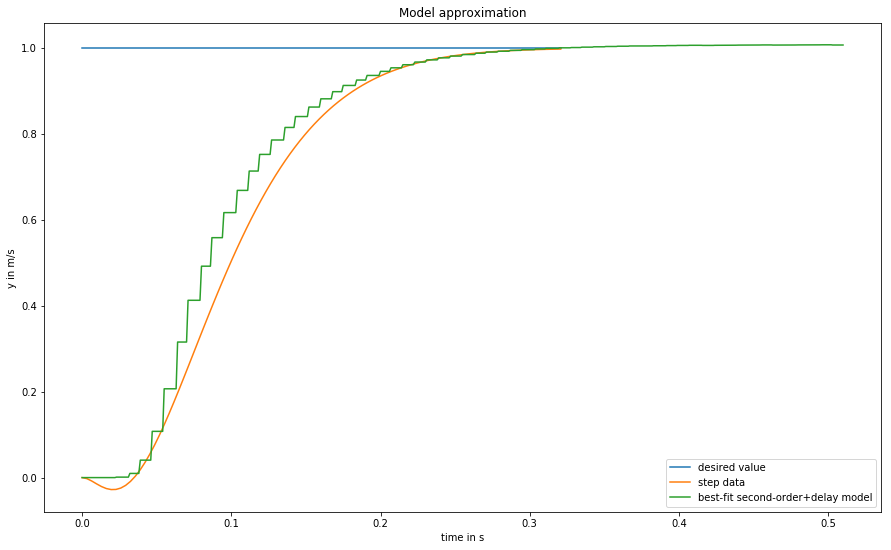

In [4]:
fnames = ["ss5_20180724-082628_poles2_ident_nodelay.npy",
          "ss5_20180724-082628_poles3_ident_pade1_0:032.npy"]

res, _ = loadtools.loadNPY(fnames[1])

pylab.rcParams['figure.figsize'] = (15, 9)

plt.title('Model approximation')
plt.plot(res['plot_model_step'][0], np.ones(len(res['plot_model_step'][0])), label="desired value")
plt.plot(*res['plot_model_step'], label="step data")
plt.plot(*res['plot_input_step'], label="best-fit second-order+delay model")

plt.ylabel('y in m/s')
plt.xlabel('time in s')

plt.legend()

plt.show()

In [5]:
_Ax, _Bx, _Cx, D = loadtools.getModel(fnames[1])
A, B, C = add_position_state(_Ax, _Bx, _Cx)


_A0x, _B0x, _C0x, D0, delay = loadtools.getDelayModel(fnames[0])
A0, B0, C0 = add_position_state(_A0x, _B0x, _C0x)

U_max = [2.0]

xx0 = [1.0, 2.0,   0.5,  0.025, 0.01]
print 'Limits on canonical state space variables:', xx0[0:len(B)]

X00 = getX00(xx0[0:len(B)])

# Transform boundaries into reachable form (to allow useful specification of boundaries)
(A1, B1, C1, D1), T1, Q1 = optim_tools.get_Steuerungsnormalform(A, B, C.T, D)
X0 = [T1.dot(x0) for x0 in X00]

Limits on canonical state space variables: [1.0, 2.0, 0.5, 0.025]


In [6]:
## Helper functions for optimization problem

def Tri(i, n_u):
    if n_u>1:
        print "Please implement: All Permutations with ones on main diagonal!"
        raise NotImplementedError()
        
    if i==1:
        return np.eye(n_u)
    else:
        # only true for n_u == 1
        return np.zeros((n_u, n_u))

def negTri(i, n_u):
    return np.eye(n_u) - Tri(i, n_u)


In [7]:
%%time

# Init
n = B.shape[0] # get dimension of system
n_u = B.shape[1] # get dimension of output

# Variables
X = cvxpy.Semidef(n)
Y = cvxpy.Semidef(n)
W = cvxpy.Variable(n_u)

Ak_h = cvxpy.Semidef(*A.shape)
Bk_h = cvxpy.Variable(*B.shape)
Ck_h = cvxpy.Variable(*C.shape)
Dk_h = cvxpy.Variable(*D.shape)

Ch = cvxpy.Variable(*C.shape)
Dh = cvxpy.Variable(*D.shape)

# Substitutionen
C_hat = lambda i: Tri(i, n_u)*Ck_h + negTri(i, n_u)*Ch
D_hat = lambda i: Tri(i, n_u)*Dk_h + negTri(i, n_u)*Dh

Xi = cvxpy.bmat([[ A*X + B*Ck_h, A + B*Dk_h*C ],
                 [ Ak_h,         Y*A + Bk_h*C ]])

I = np.eye(n)

# Bisection parameter
g = cvxpy.Parameter(sign='positive')

# Pole restriction
ro = cvxpy.Parameter(sign='positive') # Real <=-ro
ni = cvxpy.Parameter(sign='positive') # |Imag| <= ni*Real

ro.value = 100
ni.value = 10

# Define Constraints

# (7a)
const_7a = cvxpy.bmat([[X, I],
                         #[I, Y]]) >> 0
                         [I, Y]]) == cvxpy.Semidef(2*n)



# (7b)
const_7b = cvxpy.bmat([[ X*A.T + A*X + B*Ck_h + (B*Ck_h).T, Ak_h.T + A + B*Dk_h*C            ],
                         [ cvxpy.Variable(n, n),          A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) + \
             2*g*cvxpy.bmat([[X, I],
                             #[I, Y]]) << 0
                             [I, Y]]) == -cvxpy.Semidef(2*n)
    
# (7c)
const_7c = [cvxpy.bmat([[ X*A.T + A*X + B*C_hat(i) + (B*C_hat(i)).T, Ak_h.T + A + B*D_hat(i)*C            ],
                          #[ cvxpy.Variable(n, n),                      A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) << 0 for i in range(2, (2**n_u)+1)]
                          [ cvxpy.Variable(n, n),                      A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) == -cvxpy.Semidef(2*n) for i in range(2, (2**n_u)+1)]
    
    
# (7d)
const_7d = cvxpy.bmat([[ X,  I,    Ch.T     ],
                         [ I,  Y,    (Dh*C).T ],
                         #[ Ch, Dh*C, W        ]]) >> 0
                         [ Ch, Dh*C, W        ]]) == cvxpy.Semidef(2*n+n_u)

# (7e)
const_7e = [W[j,j] <= U_max[j]**2 for j in range(0, n_u)]

# (7f)
const_7f = [ X0[k].T*Y*X0[k] <= 1.0
                            for k in range(0, len(X0))]

# (7g)
const_7g = Xi.T + Xi + ro*cvxpy.bmat([[X, I],
                                        #[I, Y]]) >> 0
                                        [I, Y]]) == cvxpy.Semidef(2*n)

# (7h)
const_7h = cvxpy.bmat([[ ni*(Xi.T + Xi), Xi.T - Xi ],
                         #[ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) << 0
                         [ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) == -cvxpy.Semidef(4*n)


# Collect all constraints
constraints_7 = []
constraints_7.append(const_7a)
constraints_7.append(const_7b)
constraints_7.extend(const_7c)
constraints_7.append(const_7d)
constraints_7.extend(const_7e)
constraints_7.extend(const_7f)

constraints_7.append(const_7g)
constraints_7.append(const_7h)


# Form feasibility problem.
prob_7 = cvxpy.Problem(cvxpy.Minimize(0), constraints_7)

# bisection alternative with list of multiple solvers
[[X_o, Y_o, W_o,
  Ak_h_o, Bk_h_o, Ck_h_o, Dk_h_o,
  Ch_o, Dh_o], g_o] = optim_tools.bisect_max2(0, None, prob_7, g, [X, Y, W, Ak_h, Bk_h, Ck_h, Dk_h, Ch, Dh],
                                                      bisect_verbose=True,
                                                      bisection_tol=0.01,
                                                      solvers=[
                                                               (cvxpy.CVXOPT, {'verbose':False}),
                                                               (cvxpy.MOSEK, {'verbose':False}),
                                                               #(cvxpy.SCS, {'max_iters':5000, 'warm_start':True, 'verbose':True})
                                                              ])
print "g:", g_o

print
print '-----------------------'

processing upper bound: 1.0
processing upper bound: 2.0
processing upper bound: 4.0
processing upper bound: 8.0
processing upper bound: 16.0
processing upper bound: 32.0
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
found bounds: [16.0-32.0]
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 16.0-32.0; parameter 24.0 -> optimal
Range: 24.0-32.0; parameter 28.0 -> optimal
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 28.0-32.0; parameter 30.0 -> unknown
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 28.0-30.0; parameter 29.0 -> unknown
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed.

In [8]:
# (8)
# QR Decomposition for M and N
M, NT = LA.qr(I - X_o.dot(Y_o))
N = NT.T
# Check
assert(np.allclose(I - X_o.dot(Y_o), M.dot(N.T)))

# Reconstruction
# (9a)
Ek = -LA.solve(N, Y_o.dot(B))
# (9b)
Dk = np.matrix(Dk_h_o)

# (9c)
Ck = LA.solve(M, (Ck_h_o - Dk.dot(C).dot(X_o)).T).T
# Check
Ck_1 = (Ck_h_o - Dk.dot(C).dot(X_o)).dot(LA.inv(M).T) #Check
assert(np.allclose(Ck_1, Ck))

# (9d)
Bk = LA.solve(N, Bk_h_o)

# (9e)
temp_alpha = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o)))
temp_beta = Bk.dot(C).dot(X_o)
Ak = (LA.solve(M, temp_alpha.T) - LA.solve(M, temp_beta.T)).T
# Check
Ak_1 = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o))).dot(LA.inv(M).T) - Bk.dot(C).dot(X_o).dot(LA.inv(M).T) #Check
assert(np.allclose(Ak_1, Ak))


In [9]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:12.3f}'.format}, linewidth=130)

print "Model:\n"
print "A:\n",A,"\n"
print "B:\n",B,"\n"
print "C:\n",C,"\n"
print "D:\n",D,"\n"
print "u_max:\n",U_max,"\n"
print

print "Control System:\n"
print "Ak:\n",Ak,"\n"
print "Bk:\n",Bk,"\n"
print "Ck:\n",Ck,"\n"
print "Dk:\n",Dk,"\n"
print "Ek:\n",Ek,"\n"


Model:

A:
[[       0.000        0.000        0.000       -1.000]
 [       0.000        0.000       -0.000       35.000]
 [       0.000       10.000        0.000       32.877]
 [       0.000        0.000     -100.000     -106.143]] 

B:
[[       0.000]
 [      34.921]
 [      -5.587]
 [       0.000]] 

C:
[[       1.000        0.000        0.000        0.000]] 

D:
[[       0.000]] 

u_max:
[2.0] 


Control System:

Ak:
[[     -48.162       -1.108       -0.097        0.001]
 [     267.319      -21.440        0.908       -0.006]
 [   -4262.269       27.229      -80.439        0.272]
 [-1632995.792    37688.552    -7662.291        3.482]] 

Bk:
[[      -0.372]
 [       3.607]
 [     -71.784]
 [  -29386.828]] 

Ck:
[[   -8047.488      188.940      -32.945        0.213]] 

Dk:
[[    -145.091]] 

Ek:
[[      -0.019]
 [      -0.359]
 [       2.404]
 [    -193.735]] 



In [10]:
class control_func_dyn_out():
    def __init__(self, Ak, Bk, Ck, Dk, Ek, A, B, C, D, umax=None, dT=1e-3):
        self.Ak = Ak
        self.Bk = Bk
        self.Ck = Ck
        self.Dk = Dk
        self.Ek = Ek
        self.umax = umax
        self.dT = dT

        self.z = np.zeros(B.shape)
                
        # Construct Prefilter
        C2 = np.hstack((-C, np.zeros(Ck.shape)))

        A2_u = np.hstack(((A+B.dot(Dk).dot(C)), B.dot(Ck)))
        A2_d = np.hstack((Bk.dot(C), Ak))

        A2 = np.vstack((A2_u, A2_d))
        B2 = np.vstack((B, np.zeros(Bk.shape)))

        self.N = LA.inv(C2.dot(LA.inv(A2)).dot(B2))
        
    def estimate(self, y, u):
        # already saturated
        if self.umax is not None:
            u = optim_tools.sat(u, self.umax)
        
        z_dot = self.Ak.dot(self.z) + self.Bk.dot(y) + self.Ek.dot(u)
        return self.z + z_dot*self.dT
        
    def regulate(self, y, s, x):
        u = self.N.dot(s)+self.Ck.dot(self.z) + self.Dk.dot(y)

        # Saturate 
        if self.umax is not None:
            u = optim_tools.sat(u, self.umax)
            
        self.z = self.estimate(y, u)
        return u

In [11]:
# Timeline
T = np.arange(0, 1, 1e-3) 

#s: input, e.g., step function with amplitude of 1
s = np.ones(len(T));

In [12]:
from functools import partial

y0, u0, u0_sat = optim_tools.simulate(A, B, C, D, 
                                   partial(optim_tools.openLoop),
                                   s, T, delay=None, umax=U_max[0], x0=np.zeros(B.shape))

y1, u1, u1_sat = optim_tools.simulate(A, B, C, D, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=U_max[0]).regulate,
                                   s, T, delay=None, umax=U_max[0], x0=np.zeros(B.shape))


In [13]:
y2, u2, u2_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=U_max[0]).regulate,
                                   s, T, delay=delay, umax=U_max[0], x0=np.zeros(B0.shape))


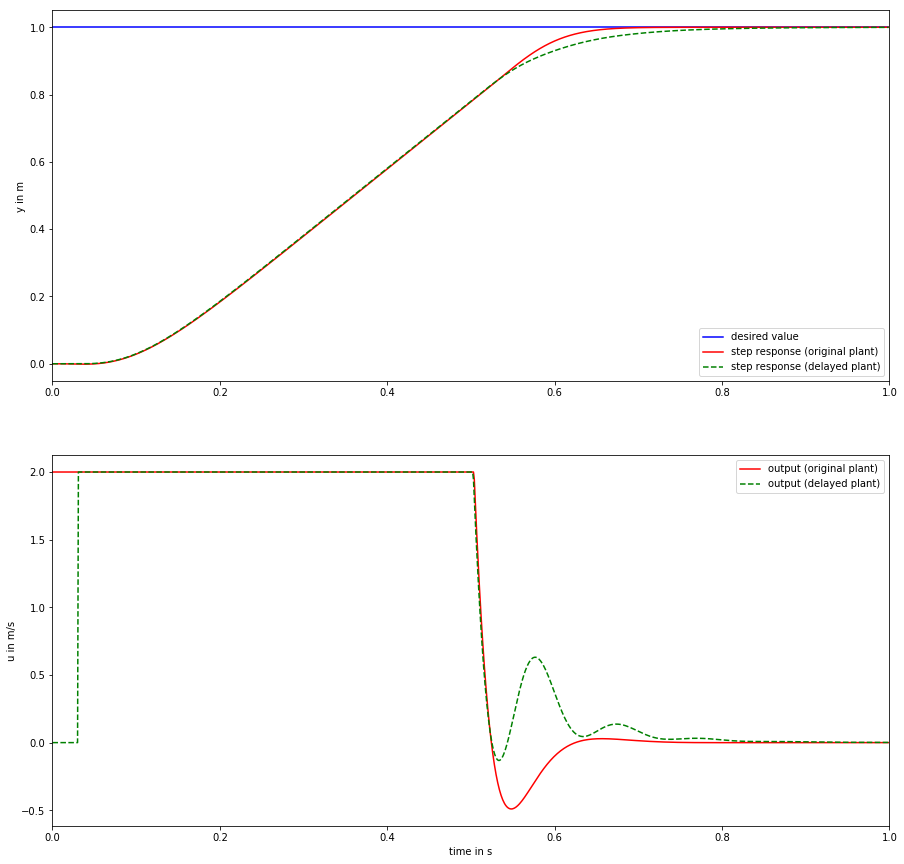

In [14]:
pylab.rcParams['figure.figsize'] = (15, 15)

ax = plt.subplot(111)
plt.title('Closed Loop Step Response')

ax1 = plt.subplot(2, 1, 1)
plt.plot(T[:], s, 'b', label='desired value')
plt.plot(T[:], np.array(y1[0,:].T), 'r', label='step response (original plant)')
plt.plot(T[:], np.array(y2[0,:].T), 'g--', label='step response (delayed plant)')

ax1.set_ylabel('y in m')
plt.xlim(0, 1)
legend()

ax2 = plt.subplot(2, 1, 2)
plt.plot(T, u1, 'r', label='output (original plant)')
plt.plot(T, u2, 'g--', label='output (delayed plant)')

ax2.set_ylabel('u in m/s')
ax2.set_xlabel('time in s')
plt.xlim(0, 1)
legend()
plt.show()
